# Image classification of cardiomyocyte tissues

This pipeline classifies cardiomyocyte images to distinguish issues from patients with chronic heart failure from ones from health donnors. It builds an image classifier using a `tf.keras.Sequential` model and load data using `tf.keras.preprocessing.image.ImageDataGenerator`. The images downloaded from https://idr.openmicroscopy.org/webclient/?show=project-402 processed with the following:

* Building _data input pipelines_ using the `tf.keras.preprocessing.image.ImageDataGenerator` class to efficiently work with data on disk to use with the model.
* _Overfitting_ —How to identify and prevent it.
* _Data augmentation_ and _dropout_ —Key techniques to fight overfitting in computer vision tasks to incorporate into the data pipeline and image classifier model.

This pipeline follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

## Import packages

It is always a good idea to import packages separately to minimise their impact on compatibility.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

Import Tensorflow and the Keras classes needed to construct our model.

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

## Load data

Download the dataset idr0042 with the OMERO 5.6.1 JSON API https://docs.openmicroscopy.org/omero/5.6.1/developers/json-api.html. The dataset is stored in the "/tmp/" directory for training and verification.

In [4]:
################################
# Create a session to access IDR
################################
import requests


def get_session() -> requests.Session:
    IDR_BASE_URL = "https://idr.openmicroscopy.org"
    INDEX_PAGE = "%s/webclient/?experimenter=-1" % IDR_BASE_URL

    # create http session
    with requests.Session() as session:
        request = requests.Request('GET', INDEX_PAGE)
        prepped = session.prepare_request(request)
        response = session.send(prepped)
        if response.status_code != 200:
            response.raise_for_status()
    return session

In [5]:
######################
# Access test data set
######################
# import json
# from IPython.display import display, HTML
import os
import tensorflow as tf

OUTPUT_PATH = '/tmp'


def download_img(ds_id: str, session: requests.Session, output_path: str = OUTPUT_PATH):
    IDR_BASE_URL = "https://idr.openmicroscopy.org"
    DS_IMG_URI = "{base}/api/v0/m/datasets/{dataset_id}/images/?limit=2500"         # test 1155, training 1144
    IMG_RDR_URI = "{base}/webgateway/render_image/{image_id}/0/0/"
    IMG_ANNO_URI = "{base}/webclient/api/annotations/?type=map&{type}={image_id}"

    qs_ds = {'base': IDR_BASE_URL, 'dataset_id': ds_id}
    r = session.get(DS_IMG_URI.format(**qs_ds))
    # print('HTTP status for image:', r.status_code)
    if r.status_code == 200:
        #     print (json.dumps(r.json()['data'][:1], indent=2, sort_keys=True))
        for img in r.json()['data']:    # [:2]:
            img_name = img['Name']
            img_id = img['@id']
            img_path = ''

            qs_img = {'base': IDR_BASE_URL, 'image_id': img_id}
            # display(HTML("<img src='%s' />" % IMG_RDR_URI.format(**qs_img)))

            qs_anno = {'base': IDR_BASE_URL, 'type': 'image', 'image_id': img_id}
            r_anno = session.get(IMG_ANNO_URI.format(**qs_anno))
            # print('HTTP status for annotation:', r_anno.status_code)
            for a in r_anno.json()['annotations']:
                for v in a['values']:
                    key = v[0]
                    value = v[1]
                    print(key, ':', value)

                    if key == 'Diagnosis' and value != 'heart tissue pathology':
                        path = os.path.join(output_path, value.replace(" ", "_"))
                        if not os.path.exists(path):
                            os.system("mkdir -p " + path)
                        img_path = tf.keras.utils.get_file(fname=os.path.join(path, img_name), origin=IMG_RDR_URI.format(**qs_img))
            print(img_name, img_id, img_path)
            print('')       # pretty print
    return output_path


# dataset IDs
DS_TEST_ID = "827"
DS_TRAIN_ID = "828"

validation_dir: str = download_img(ds_id=DS_TEST_ID, session=get_session(), output_path=os.path.join(OUTPUT_PATH, 'validation'))
train_dir: str = download_img(ds_id=DS_TRAIN_ID, session=get_session(), output_path=os.path.join(OUTPUT_PATH, 'train'))

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 47 years
Individual : 33375
Clinical History : non-ischemic cardiomyopathy
33375_0_fal_1_0.png 3428066 /tmp/validation/chronic_heart_failure/33375_0_fal_1_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 47 years
Individual : 33375
Clinical History : non-ischemic cardiomyopathy
33375_0_fal_20_0.png 3428067 /tmp/validation/chronic_heart_failure/33375_0_fal_20_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 47 years
Individual : 33375
Clinical History : non-ischemic cardiomyopathy
33375_0_fal_23_0.png 3428068 /tmp/validation/chronic_heart_

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 60 years
Individual : 33388
Clinical History : ischemic cardiomyopathy
33388_0_fal_19_0.png 3428093 /tmp/validation/chronic_heart_failure/33388_0_fal_19_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 60 years
Individual : 33388
Clinical History : ischemic cardiomyopathy
33388_0_fal_20_0.png 3428095 /tmp/validation/chronic_heart_failure/33388_0_fal_20_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 60 years
Individual : 33388
Clinical History : ischemic cardiomyopathy
33388_0_fal_2_0.png 3428098 /tmp/validatio

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 44 years
Individual : 33395
Clinical History : non-ischemic cardiomyopathy
33395_0_fal_10_0.png 3428121 /tmp/validation/chronic_heart_failure/33395_0_fal_10_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 44 years
Individual : 33395
Clinical History : non-ischemic cardiomyopathy
33395_0_fal_14_0.png 3428122 /tmp/validation/chronic_heart_failure/33395_0_fal_14_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 44 years
Individual : 33395
Clinical History : non-ischemic cardiomyopathy
33395_0_fal_19_0.png 3428123 /tmp/validation/chronic_hear

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 52 years
Individual : 33401
Clinical History : ischemic cardiomyopathy
33401_0_fal_3_0.png 3428152 /tmp/validation/chronic_heart_failure/33401_0_fal_3_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 52 years
Individual : 33401
Clinical History : ischemic cardiomyopathy
33401_0_fal_32_0.png 3428150 /tmp/validation/chronic_heart_failure/33401_0_fal_32_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 52 years
Individual : 33401
Clinical History : ischemic cardiomyopathy
33401_0_fal_35_0.png 3428151 /tmp/validation

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 67 years
Individual : 33407
Clinical History : non-ischemic cardiomyopathy
33407_0_fal_20_0.png 3428180 /tmp/validation/chronic_heart_failure/33407_0_fal_20_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 67 years
Individual : 33407
Clinical History : non-ischemic cardiomyopathy
33407_0_fal_23_0.png 3428181 /tmp/validation/chronic_heart_failure/33407_0_fal_23_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 67 years
Individual : 33407
Clinical History : non-ischemic cardiomyopathy
33407_0_fal_25_0.png 3428182 /tmp/validation/chronic_hear

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 33409
Clinical History : ischemic cardiomyopathy
33409_0_fal_7_0.png 3428208 /tmp/validation/chronic_heart_failure/33409_0_fal_7_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 60 years
Individual : 33414
Clinical History : ischemic cardiomyopathy
33414_0_fal_1_0.png 3428211 /tmp/validation/chronic_heart_failure/33414_0_fal_1_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 60 years
Individual : 33414
Clinical History : ischemic cardiomyopathy
33414_0_fal_11_0.png 3428209 /tm

Clinical History : non-ischemic cardiomyopathy
33417_0_fal_29_0.png 3428235 /tmp/validation/chronic_heart_failure/33417_0_fal_29_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 58 years
Individual : 33417
Clinical History : non-ischemic cardiomyopathy
33417_0_fal_39_0.png 3428236 /tmp/validation/chronic_heart_failure/33417_0_fal_39_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 58 years
Individual : 33417
Clinical History : non-ischemic cardiomyopathy
33417_0_fal_44_0.png 3428237 /tmp/validation/chronic_heart_failure/33417_0_fal_44_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 64 years
Individual : 33424
Clinical History : ischemic cardiomyopathy
33424_0_fal_15_0.png 3428265 /tmp/validation/chronic_heart_failure/33424_0_fal_15_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 64 years
Individual : 33424
Clinical History : ischemic cardiomyopathy
33424_0_fal_19_0.png 3428266 /tmp/validation/chronic_heart_failure/33424_0_fal_19_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 64 years
Individual : 33424
Clinical History : ischemic cardiomyopathy
334

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 66 years
Individual : 33467
Clinical History : non-ischemic cardiomyopathy
33467_0_fal_35_0.png 3428291 /tmp/validation/chronic_heart_failure/33467_0_fal_35_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 66 years
Individual : 33467
Clinical History : non-ischemic cardiomyopathy
33467_0_fal_38_0.png 3428292 /tmp/validation/chronic_heart_failure/33467_0_fal_38_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 66 years
Individual : 33467
Clinical History : non-ischemic cardiomyopathy
33467_0_fal_46_0.png 3428294 /tmp/validation/chronic_hear

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 63 years
Individual : 33476
Clinical History : non-ischemic cardiomyopathy
33476_0_fal_18_0.png 3428319 /tmp/validation/chronic_heart_failure/33476_0_fal_18_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 63 years
Individual : 33476
Clinical History : non-ischemic cardiomyopathy
33476_0_fal_26_0.png 3428321 /tmp/validation/chronic_heart_failure/33476_0_fal_26_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 63 years
Individual : 33476
Clinical History : non-ischemic cardiomyopathy
33476_0_fal_27_0.png 3428322 /tmp/va

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 65 years
Individual : 33480
Clinical History : ischemic cardiomyopathy
33480_0_fal_16_0.png 3428347 /tmp/validation/chronic_heart_failure/33480_0_fal_16_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 65 years
Individual : 33480
Clinical History : ischemic cardiomyopathy
33480_0_fal_17_0.png 3428348 /tmp/validation/chronic_heart_failure/33480_0_fal_17_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 65 years
Individual : 33480
Clinical History : ischemic cardiomyopathy
33480_0_fal_18_0.png 3428349 /tmp/validati

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 64 years
Individual : 33484
Clinical History : ischemic cardiomyopathy
33484_0_fal_9_0.png 3428373 /tmp/validation/chronic_heart_failure/33484_0_fal_9_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 67 years
Individual : 33490
Clinical History : non-ischemic cardiomyopathy
33490_0_fal_1_0.png 3428377 /tmp/validation/chronic_heart_failure/33490_0_fal_1_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 67 years
Individual : 33490
Clinical History : non-ischemic cardiomyopathy
33490_0_fal_13_0.png 3428374 /tmp/validation/chronic_hea

Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 68 years
Individual : 33538
Clinical History : ischemic cardiomyopathy
33538_0_fal_22_0.png 3428401 /tmp/validation/chronic_heart_failure/33538_0_fal_22_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 68 years
Individual : 33538
Clinical History : ischemic cardiomyopathy
33538_0_fal_27_0.png 3428402 /tmp/validation/chronic_heart_failure/33538_0_fal_27_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 68 years
Individual : 33538
Clinical History : ischemic cardiomyopathy
33538_0_fal_36_0.png 3428404 /tmp/validation/chronic_heart_failure/33538_0_fal_36_0.png

Organism 

Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 33545
Clinical History : ischemic cardiomyopathy
33545_0_fal_2_0.png 3428431 /tmp/validation/chronic_heart_failure/33545_0_fal_2_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 33545
Clinical History : ischemic cardiomyopathy
33545_0_fal_27_0.png 3428430 /tmp/validation/chronic_heart_failure/33545_0_fal_27_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 33545
Clinical History : ischemic cardiomyopathy
33545_0_fal_30_0.png 3428432 /tmp/validation/chronic_heart_failure/33545_0_fal_30_0.png

Organism : Homo sapiens
Channels : RGB
Organism Pa

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 31 years
Individual : 33548
Clinical History : non-ischemic cardiomyopathy
33548_0_fal_26_0.png 3428457 /tmp/validation/chronic_heart_failure/33548_0_fal_26_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 31 years
Individual : 33548
Clinical History : non-ischemic cardiomyopathy
33548_0_fal_31_0.png 3428458 /tmp/validation/chronic_heart_failure/33548_0_fal_31_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 31 years
Individual : 33548
Clinical History : non-ischemic cardiomyopathy
33548_0_fal_33_0.p

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 59 years
Individual : 34072
Clinical History : normal cardiovascular function by cardiac catheterization
34072_1_nrm_11_0.png 3428484 /tmp/validation/not_chronic_heart_failure/34072_1_nrm_11_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 59 years
Individual : 34072
Clinical History : normal cardiovascular function by cardiac catheterization
34072_1_nrm_12_0.png 3428485 /tmp/validation/not_chronic_heart_failure/34072_1_nrm_12_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 59 years
Individual : 34072
Clinical History : normal cardiovascular function by cardiac catheterization
34072_1_nrm_14_0.png 3428486 /tmp/validation/n

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 57 years
Individual : 34074
Clinical History : non-ischemic cardiomyopathy
34074_0_fal_7_0.png 3428515 /tmp/validation/chronic_heart_failure/34074_0_fal_7_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 57 years
Individual : 34074
Clinical History : non-ischemic cardiomyopathy
34074_0_fal_9_0.png 3428516 /tmp/validation/chronic_heart_failure/34074_0_fal_9_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 19 years
Individual : 34076
Clinical History : non-ischemic cardiomyopathy
34076_0_fal_10_0.png 3428517 /tmp/validation/chronic_heart_fa

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Unknown racial group
Age : 46 years
Individual : 34083
Clinical History : non-ischemic cardiomyopathy
34083_0_fal_19_0.png 3428546 /tmp/validation/chronic_heart_failure/34083_0_fal_19_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Unknown racial group
Age : 46 years
Individual : 34083
Clinical History : non-ischemic cardiomyopathy
34083_0_fal_20_0.png 3428547 /tmp/validation/chronic_heart_failure/34083_0_fal_20_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Unknown racial group
Age : 46 years
Individual : 34083
Clinical History : non-ischemic cardiomyopathy
34083_0_fal_2_0.png 3428

Sex : female
Ethnic or Racial Group : Caucasian
Age : 54 years
Individual : 34086
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
34086_1_nrm_22_0.png 3428570 /tmp/validation/not_chronic_heart_failure/34086_1_nrm_22_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : heart tissue pathology
Disease Subtype : myocardium disease
Sex : male
Ethnic or Racial Group : Caucasian
Age : 24 years
Individual : 34088
Clinical History : donor without a history of chronic symptomatic heart failure but tissue pathology
34088_1_nrm_10_0.png 3428572 

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : heart tissue pathology
Disease Subtype : myocardium disease
Sex : male
Ethnic or Racial Group : Caucasian
Age : 24 years
Individual : 34088
Clinical History : donor without a history of chronic symptomatic heart failure but tissue pathology
34088_1_nrm_1_0.png 3428578 

Organ

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 65 years
Individual : 34090
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
34090_1_nrm_17_0.png 3428599 /tmp/validation/not_chronic_heart_failure/34090_1_nrm_17_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 65 years
Individual : 34090
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
34090_1_nrm_18_0.png 3428600 /tmp/validation/not_chronic_heart_failure/34090_1_nrm_18_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 65 years
Individual : 34090
Clinical 

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Race not stated
Age : 61 years
Individual : 34231
Clinical History : non-ischemic cardiomyopathy
34231_0_fal_28_0.png 3428625 /tmp/validation/chronic_heart_failure/34231_0_fal_28_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Caucasian
Age : 53 years
Individual : 34238
Clinical History : non-ischemic cardiomyopathy
34238_0_fal_10_0.png 3428627 /tmp/validation/chronic_heart_failure/34238_0_fal_10_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Caucasian
Age : 53 years
Individual : 34238
Clinical History : non-ischemic cardiomyopathy
34238_0_fal_1_0.png 3428634 /tmp/validation/c

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 59 years
Individual : 34296
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
34296_1_nrm_36_0.png 3428654 /tmp/validation/not_chronic_heart_failure/34296_1_nrm_36_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 59 years
Individual : 34296
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
34296_1_nrm_37_0.png 3428655 /tmp/validation/not_chronic_heart_failure/34296_1_nrm_37_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 59 years
Individual : 34296
Clinical 

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 71 years
Individual : 35590
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35590_1_nrm_4_0.png 3428681 /tmp/validation/not_chronic_heart_failure/35590_1_nrm_4_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 71 years
Individual : 35590
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35590_1_nrm_41_0.png 3428678 /tmp/validation/not_chronic_heart_failure/35590_1_nrm_41_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 71 years
Individual : 35590
Clinical History 

Ethnic or Racial Group : African American
Age : 73 years
Individual : 35597
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35597_1_nrm_10_0.png 3428704 /tmp/validation/not_chronic_heart_failure/35597_1_nrm_10_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : African American
Age : 73 years
Individual : 35597
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35597_1_nrm_11_0.png 3428705 /tmp/validation/not_chronic_heart_failure/35597_1_nrm_11_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : African American
Age : 73 years
Individual : 35597
Clinical History : donor without a history of chronic heart failure but no definitive tests showing 

Sex : male
Ethnic or Racial Group : African American
Age : 53 years
Individual : 35601
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35601_1_nrm_3_0.png 3428732 /tmp/validation/not_chronic_heart_failure/35601_1_nrm_3_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 53 years
Individual : 35601
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35601_1_nrm_37_0.png 3428731 /tmp/validation/not_chronic_heart_failure/35601_1_nrm_37_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 53 years
Individual : 35601
Clinical History : donor without a history of chronic heart failure but no definitive tests sho

Sex : male
Ethnic or Racial Group : Hispanic
Age : 44 years
Individual : 35606
Clinical History : normal cardiovascular function by cardiac catheterization
35606_1_nrm_18_0.png 3428762 /tmp/validation/not_chronic_heart_failure/35606_1_nrm_18_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Hispanic
Age : 44 years
Individual : 35606
Clinical History : normal cardiovascular function by cardiac catheterization
35606_1_nrm_19_0.png 3428763 /tmp/validation/not_chronic_heart_failure/35606_1_nrm_19_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Hispanic
Age : 44 years
Individual : 35606
Clinical History : normal cardiovascular function by cardiac catheterization
35606_1_nrm_20_0.png 3428764 /tmp/validation/not_chronic_heart_failure/35606_1_nrm_20_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : 

Sex : female
Ethnic or Racial Group : African American
Age : 20 years
Individual : 35609
Clinical History : normal cardiovascular function by cardiac catheterization
35609_1_nrm_2_0.png 3428787 /tmp/validation/not_chronic_heart_failure/35609_1_nrm_2_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : African American
Age : 20 years
Individual : 35609
Clinical History : normal cardiovascular function by cardiac catheterization
35609_1_nrm_26_0.png 3428786 /tmp/validation/not_chronic_heart_failure/35609_1_nrm_26_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : African American
Age : 20 years
Individual : 35609
Clinical History : normal cardiovascular function by cardiac catheterization
35609_1_nrm_33_0.png 3428788 /tmp/validation/not_chronic_heart_failure/35609_1_nrm_33_0.png

Organism : Homo sapiens
Cha

Sex : female
Ethnic or Racial Group : Caucasian
Age : 65 years
Individual : 35626
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35626_1_nrm_10_0.png 3428814 /tmp/validation/not_chronic_heart_failure/35626_1_nrm_10_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 65 years
Individual : 35626
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35626_1_nrm_1_0.png 3428822 /tmp/validation/not_chronic_heart_failure/35626_1_nrm_1_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 65 years
Individual : 35626
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal car

Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Hispanic
Age : 51 years
Individual : 35629
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35629_1_nrm_27_0.png 3428842 /tmp/validation/not_chronic_heart_failure/35629_1_nrm_27_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Hispanic
Age : 51 years
Individual : 35629
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35629_1_nrm_30_0.png 3428843 /tmp/validation/not_chronic_heart_failure/35629_1_nrm_30_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Hispanic
Age : 51 years
Individual : 35629
Clinical History : donor without a history

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 61 years
Individual : 35632
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35632_1_nrm_7_0.png 3428867 /tmp/validation/not_chronic_heart_failure/35632_1_nrm_7_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 61 years
Individual : 35632
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35632_1_nrm_9_0.png 3428868 /tmp/validation/not_chronic_heart_failure/35632_1_nrm_9_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 48 years
Individual : 35635
Clinical History : 

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Hispanic
Age : 37 years
Individual : 35638
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35638_1_nrm_43_0.png 3428896 /tmp/validation/not_chronic_heart_failure/35638_1_nrm_43_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Hispanic
Age : 37 years
Individual : 35638
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35638_1_nrm_45_0.png 3428897 /tmp/validation/not_chronic_heart_failure/35638_1_nrm_45_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Hispanic
Age : 37 years
Individual : 35638
Clinical His

Sex : male
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 35646
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35646_1_nrm_10_0.png 3428924 /tmp/validation/not_chronic_heart_failure/35646_1_nrm_10_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 35646
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35646_1_nrm_1_0.png 3428928 /tmp/validation/not_chronic_heart_failure/35646_1_nrm_1_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 35646
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovas

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : African American
Age : 50 years
Individual : 35651
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35651_1_nrm_28_0.png 3428949 /tmp/validation/not_chronic_heart_failure/35651_1_nrm_28_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : African American
Age : 50 years
Individual : 35651
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35651_1_nrm_29_0.png 3428950 /tmp/validation/not_chronic_heart_failure/35651_1_nrm_29_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : African American
Age : 50 years
Individ

Sex : male
Ethnic or Racial Group : Caucasian
Age : 62 years
Individual : 35880
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35880_1_nrm_14_0.png 3428972 /tmp/validation/not_chronic_heart_failure/35880_1_nrm_14_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 62 years
Individual : 35880
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35880_1_nrm_15_0.png 3428973 /tmp/validation/not_chronic_heart_failure/35880_1_nrm_15_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 62 years
Individual : 35880
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiov

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 36116
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36116_1_nrm_1_0.png 3429003 /tmp/validation/not_chronic_heart_failure/36116_1_nrm_1_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 36116
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36116_1_nrm_15_0.png 3429002 /tmp/validation/not_chronic_heart_failure/36116_1_nrm_15_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 36116
Clinical Hi

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 78 years
Individual : 36121
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36121_1_nrm_43_0.png 3429031 /tmp/validation/not_chronic_heart_failure/36121_1_nrm_43_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 78 years
Individual : 36121
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36121_1_nrm_45_0.png 3429032 /tmp/validation/not_chronic_heart_failure/36121_1_nrm_45_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 78 years
Individual : 36121
Clinical 

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 77 years
Individual : 36135
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36135_1_nrm_27_0.png 3429061 /tmp/validation/not_chronic_heart_failure/36135_1_nrm_27_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 77 years
Individual : 36135
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36135_1_nrm_35_0.png 3429062 /tmp/validation/not_chronic_heart_failure/36135_1_nrm_35_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 77 years
Individual : 36135
Clinical 

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 61 years
Individual : 33383
Clinical History : ischemic cardiomyopathy
33383_0_fal_47_0.png 3429625 /tmp/train/chronic_heart_failure/33383_0_fal_47_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 61 years
Individual : 33383
Clinical History : ischemic cardiomyopathy
33383_0_fal_50_0.png 3429626 /tmp/train/chronic_heart_failure/33383_0_fal_50_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 61 years
Individual : 33383
Clinical History : ischemic cardiomyopathy
33383_0_fal_9_0.png 3429627 /tmp/train/chronic_heart

Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 59 years
Individual : 33392
Clinical History : ischemic cardiomyopathy
33392_0_fal_28_0.png 3429642 /tmp/train/chronic_heart_failure/33392_0_fal_28_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 59 years
Individual : 33392
Clinical History : ischemic cardiomyopathy
33392_0_fal_3_0.png 3429644 /tmp/train/chronic_heart_failure/33392_0_fal_3_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 59 years
Individual : 33392
Clinical History : ischemic cardiomyopathy
33392_0_fal_39_0.png 3429643 /tmp/train/chronic_heart_failure/33392_0_fal_39_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diag

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 18 years
Individual : 33398
Clinical History : non-ischemic cardiomyopathy
33398_0_fal_1_0.png 3429233 /tmp/train/chronic_heart_failure/33398_0_fal_1_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 18 years
Individual : 33398
Clinical History : non-ischemic cardiomyopathy
33398_0_fal_16_0.png 3429232 /tmp/train/chronic_heart_failure/33398_0_fal_16_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 18 years
Individual : 33398
Clinical History : non-ischemic cardiomyopathy
33398_0_fal_3_0.png 3429236 /tmp/train/chronic_heart_failure/33398_0_

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 19 years
Individual : 33403
Clinical History : non-ischemic cardiomyopathy
33403_0_fal_32_0.png 3429675 /tmp/train/chronic_heart_failure/33403_0_fal_32_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 19 years
Individual : 33403
Clinical History : non-ischemic cardiomyopathy
33403_0_fal_34_0.png 3429676 /tmp/train/chronic_heart_failure/33403_0_fal_34_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 19 years
Individual : 33403
Clinical History : non-ischemic cardiomyopathy
33403_0_fal_40_0.png 3429677 /tmp/train/chronic_heart_failure/33403

Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 53 years
Individual : 33411
Clinical History : non-ischemic cardiomyopathy
33411_0_fal_32_0.png 3429690 /tmp/train/chronic_heart_failure/33411_0_fal_32_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 53 years
Individual : 33411
Clinical History : non-ischemic cardiomyopathy
33411_0_fal_35_0.png 3429691 /tmp/train/chronic_heart_failure/33411_0_fal_35_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 53 years
Individual : 33411
Clinical History : non-ischemic cardiomyopathy
33411_0_fal_45_0.png 3429692 /tmp/train/chronic_heart_failure/33411_0_fal_45_0.png

Organis

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 49 years
Individual : 33415
Clinical History : non-ischemic cardiomyopathy
33415_0_fal_10_0.png 3429716 /tmp/train/chronic_heart_failure/33415_0_fal_10_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 49 years
Individual : 33415
Clinical History : non-ischemic cardiomyopathy
33415_0_fal_14_0.png 3429717 /tmp/train/chronic_heart_failure/33415_0_fal_14_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 49 years
Individual : 33415
Clinical History : non-ischemic cardiomyopathy
33415_0_fal_3_0.png 3429719 /tmp/train/chronic_heart_failure/33415_

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 55 years
Individual : 33419
Clinical History : ischemic cardiomyopathy
33419_0_fal_28_0.png 3429744 /tmp/train/chronic_heart_failure/33419_0_fal_28_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 55 years
Individual : 33419
Clinical History : ischemic cardiomyopathy
33419_0_fal_33_0.png 3429745 /tmp/train/chronic_heart_failure/33419_0_fal_33_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 55 years
Individual : 33419
Clinical History : ischemic cardiomyopathy
33419_0_fal_4

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 53 years
Individual : 33422
Clinical History : non-ischemic cardiomyopathy
33422_0_fal_43_0.png 3429758 /tmp/train/chronic_heart_failure/33422_0_fal_43_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 53 years
Individual : 33422
Clinical History : non-ischemic cardiomyopathy
33422_0_fal_44_0.png 3429759 /tmp/train/chronic_heart_failure/33422_0_fal_44_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 45 years
Individual : 33425
Clinical History : ischemic cardiomyopathy
33425_0_fal_1_0.png 342

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 62 years
Individual : 33471
Clinical History : ischemic cardiomyopathy
33471_0_fal_14_0.png 3429763 /tmp/train/chronic_heart_failure/33471_0_fal_14_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 62 years
Individual : 33471
Clinical History : ischemic cardiomyopathy
33471_0_fal_17_0.png 3429764 /tmp/train/chronic_heart_failure/33471_0_fal_17_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 62 years
Individual : 33471
Clinical History : ischemic cardiomyopathy
33471_0_fal_18_0.png 3429765 /tmp/train/chronic_hear

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 27 years
Individual : 33478
Clinical History : ischemic cardiomyopathy
33478_0_fal_9_0.png 3429792 /tmp/train/chronic_heart_failure/33478_0_fal_9_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 67 years
Individual : 33479
Clinical History : ischemic cardiomyopathy
33479_0_fal_10_0.png 3429793 /tmp/train/chronic_heart_failure/33479_0_fal_10_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 67 years
Individual : 33479
Clinical History : ischemic cardiomyopathy
33479_0_fal_16_0.png 3429794 /tmp/train/chronic_heart_

Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 54 years
Individual : 33485
Clinical History : ischemic cardiomyopathy
33485_0_fal_12_0.png 3429817 /tmp/train/chronic_heart_failure/33485_0_fal_12_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 54 years
Individual : 33485
Clinical History : ischemic cardiomyopathy
33485_0_fal_14_0.png 3429818 /tmp/train/chronic_heart_failure/33485_0_fal_14_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 54 years
Individual : 33485
Clinical History : ischemic cardiomyopathy
33485_0_fal_15_0.png 3429819 /tmp/train/chronic_heart_failure/33485_0_fal_15_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Di

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 63 years
Individual : 33487
Clinical History : ischemic cardiomyopathy
33487_0_fal_51_0.png 3429846 /tmp/train/chronic_heart_failure/33487_0_fal_51_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 55 years
Individual : 33489
Clinical History : ischemic cardiomyopathy
33489_0_fal_1_0.png 3429850 /tmp/train/chronic_heart_failure/33489_0_fal_1_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 55 years
Individual : 33489
Clinical History : ischemic cardiomyopathy
33489_0_fal_13_0.png 3429848 /tmp/train/chronic_heart_

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 23 years
Individual : 33540
Clinical History : non-ischemic cardiomyopathy
33540_0_fal_30_0.png 3429303 /tmp/train/chronic_heart_failure/33540_0_fal_30_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 23 years
Individual : 33540
Clinical History : non-ischemic cardiomyopathy
33540_0_fal_3_0.png 3429306 /tmp/train/chronic_heart_failure/33540_0_fal_3_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 23 years
Individual : 33540
Clinical History : non-ischemic cardiomyopathy
33540_0_fal_32_0.png 3429304 /tmp/train/chronic_heart_failure/33540_0

Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 59 years
Individual : 33547
Clinical History : non-ischemic cardiomyopathy
33547_0_fal_12_0.png 3429893 /tmp/train/chronic_heart_failure/33547_0_fal_12_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 59 years
Individual : 33547
Clinical History : non-ischemic cardiomyopathy
33547_0_fal_16_0.png 3429894 /tmp/train/chronic_heart_failure/33547_0_fal_16_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 59 years
Individual : 33547
Clinical History : non-ischemic cardiomyopathy
33547_0_fal_17_0.png 3429895 /tmp/train/chronic_heart_failure/33547_0_fal_17_0.png

Organism : Homo sapiens
Channels : RGB


Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 58 years
Individual : 33551
Clinical History : non-ischemic cardiomyopathy
33551_0_fal_35_0.png 3429326 /tmp/train/chronic_heart_failure/33551_0_fal_35_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 58 years
Individual : 33551
Clinical History : non-ischemic cardiomyopathy
33551_0_fal_36_0.png 3429327 /tmp/train/chronic_heart_failure/33551_0_fal_36_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 58 years
Individual : 33551
Clinical History : non-ischemic cardiomyopathy
33551_0_fal_45_0.png 3429328 /tmp/train/chroni

Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 58 years
Individual : 33553
Clinical History : normal cardiovascular function by cardiac catheterization
33553_1_nrm_18_0.png 3429922 /tmp/train/not_chronic_heart_failure/33553_1_nrm_18_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 58 years
Individual : 33553
Clinical History : normal cardiovascular function by cardiac catheterization
33553_1_nrm_19_0.png 3429923 /tmp/train/not_chronic_heart_failure/33553_1_nrm_19_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 59 years
Individual : 33554
Clinical History : non-ischemic cardiomyopathy
33554_0_fal_16_0.png 3429331 /tmp/train/chronic_heart_failure/33554_0_fal_16_0.png

Organism : Homo sapiens
Channels : RGB
Organis

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 76 years
Individual : 34075
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
34075_1_nrm_2_0.png 3429357 /tmp/train/not_chronic_heart_failure/34075_1_nrm_2_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 76 years
Individual : 34075
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
34075_1_nrm_24_0.png 3429356 /tmp/train/not_chronic_heart_failure/34075_1_nrm_24_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 76 years
Individual : 34075
Clinical History : donor wi

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 34079
Clinical History : ischemic cardiomyopathy
34079_0_fal_36_0.png 3429944 /tmp/train/chronic_heart_failure/34079_0_fal_36_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 34079
Clinical History : ischemic cardiomyopathy
34079_0_fal_37_0.png 3429945 /tmp/train/chronic_heart_failure/34079_0_fal_37_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 34079
Clinical History : ischemic cardiomyopathy
34079_0_fal_39_0.png 3429946 /tmp/train/chronic_hear

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 42 years
Individual : 34082
Clinical History : non-ischemic cardiomyopathy
34082_0_fal_5_0.png 3429373 /tmp/train/chronic_heart_failure/34082_0_fal_5_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 42 years
Individual : 34082
Clinical History : non-ischemic cardiomyopathy
34082_0_fal_8_0.png 3429374 /tmp/train/chronic_heart_failure/34082_0_fal_8_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Race not stated
Age : 53 years
Individual : 34084
Clinical History : non-ischemic cardiomyopathy
34084_0_fal_14_0.png 3429375 /tmp/train/chronic_heart_failure/340

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 40 years
Individual : 34277
Clinical History : no documentation of ischemic vs non-ischemic etiology
34277_0_fal_42_0.png 3429391 /tmp/train/chronic_heart_failure/34277_0_fal_42_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 40 years
Individual : 34277
Clinical History : no documentation of ischemic vs non-ischemic etiology
34277_0_fal_44_0.png 3429392 /tmp/train/chronic_heart_failure/34277_0_fal_44_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 40 years
Individual : 34277
Clinical History : no documentation of ischemic vs non-ischemic etiology
34277_0_fal_47_0.png 3429393 /tmp/train/chronic_heart_failure/34277_0_fal_47_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Hispanic
Age : 61 years
Individual : 35593
Clinical History : normal cardiovascular function by cardiac catheterization
35593_1_nrm_19_0.png 3429992 /tmp/train/not_chronic_heart_failure/35593_1_nrm_19_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Hispanic
Age : 61 years
Individual : 35593
Clinical History : normal cardiovascular function by cardiac catheterization
35593_1_nrm_2_0.png 3429995 /tmp/train/not_chronic_heart_failure/35593_1_nrm_2_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Hispanic
Age : 61 years
Individual : 35593
Clinical History : normal cardiovascular function by cardiac catheterization
35593_1_nrm_23_0.png 3429993 /tmp/train/not_chronic_heart_fai

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Hispanic
Age : 68 years
Individual : 35598
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35598_1_nrm_32_0.png 3430007 /tmp/train/not_chronic_heart_failure/35598_1_nrm_32_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Hispanic
Age : 68 years
Individual : 35598
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35598_1_nrm_43_0.png 3430008 /tmp/train/not_chronic_heart_failure/35598_1_nrm_43_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Hispanic
Age : 68 years
Individual : 35598
Clinical History : don

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Ethnic or Racial Group : Unknown racial group
Individual : 35605
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35605_1_nrm_22_0.png 3429421 /tmp/train/not_chronic_heart_failure/35605_1_nrm_22_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Ethnic or Racial Group : Unknown racial group
Individual : 35605
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35605_1_nrm_25_0.png 3429422 /tmp/train/not_chronic_heart_failure/35605_1_nrm_25_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Ethnic or Racial Group : Unknown racial group
Individual : 35605
Clinical History : donor without a history of chronic heart failure bu

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 61 years
Individual : 35623
Clinical History : normal cardiovascular function by cardiac catheterization
35623_1_nrm_43_0.png 3430044 /tmp/train/not_chronic_heart_failure/35623_1_nrm_43_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 61 years
Individual : 35623
Clinical History : normal cardiovascular function by cardiac catheterization
35623_1_nrm_47_0.png 3430045 /tmp/train/not_chronic_heart_failure/35623_1_nrm_47_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 51 years
Individual : 35624
Clinical History : normal cardiovascular function by cardiac catheterization
35624_1_nrm_2_0.png 3430048 /tmp/train/not_ch

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 45 years
Individual : 35631
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35631_1_nrm_12_0.png 3429443 /tmp/train/not_chronic_heart_failure/35631_1_nrm_12_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 45 years
Individual : 35631
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35631_1_nrm_13_0.png 3429444 /tmp/train/not_chronic_heart_failure/35631_1_nrm_13_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 45 years
Individual : 35631
Clinical History : 

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 24 years
Individual : 35634
Clinical History : normal cardiovascular function by cardiac catheterization
35634_1_nrm_47_0.png 3430077 /tmp/train/not_chronic_heart_failure/35634_1_nrm_47_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 24 years
Individual : 35634
Clinical History : normal cardiovascular function by cardiac catheterization
35634_1_nrm_6_0.png 3430078 /tmp/train/not_chronic_heart_failure/35634_1_nrm_6_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 35636
Clinical History : normal cardiovascular function by cardiac catheterization
35636_1_nrm_10_0.png 3430079 /tmp/train/not_chronic_he

Sex : male
Ethnic or Racial Group : African American
Age : 46 years
Individual : 35641
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35641_1_nrm_30_0.png 3430093 /tmp/train/not_chronic_heart_failure/35641_1_nrm_30_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 46 years
Individual : 35641
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35641_1_nrm_32_0.png 3430094 /tmp/train/not_chronic_heart_failure/35641_1_nrm_32_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 46 years
Individual : 35641
Clinical History : donor without a history of chronic heart failure but no definitive tests showing nor

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 59 years
Individual : 35645
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35645_1_nrm_48_0.png 3430120 /tmp/train/not_chronic_heart_failure/35645_1_nrm_48_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 59 years
Individual : 35645
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35645_1_nrm_49_0.png 3430121 /tmp/train/not_chronic_heart_failure/35645_1_nrm_49_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 59 years
Individual : 35645
Clin

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 67 years
Individual : 35650
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35650_1_nrm_18_0.png 3430147 /tmp/train/not_chronic_heart_failure/35650_1_nrm_18_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 67 years
Individual : 35650
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35650_1_nrm_32_0.png 3430149 /tmp/train/not_chronic_heart_failure/35650_1_nrm_32_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 67 years
Individual : 35650
Clinical History : 

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 35877
Clinical History : normal cardiovascular function by cardiac catheterization
35877_1_nrm_17_0.png 3430174 /tmp/train/not_chronic_heart_failure/35877_1_nrm_17_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 35877
Clinical History : normal cardiovascular function by cardiac catheterization
35877_1_nrm_18_0.png 3430175 /tmp/train/not_chronic_heart_failure/35877_1_nrm_18_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 35877
Clinical History : normal cardiovascular function by cardiac catheterization
35877_1_nrm_19_0.png 3430176 /tmp/train/not_chronic_hear

Age : 40 years
Individual : 36111
Clinical History : normal cardiovascular function by cardiac catheterization
36111_1_nrm_38_0.png 3430196 /tmp/train/not_chronic_heart_failure/36111_1_nrm_38_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 40 years
Individual : 36111
Clinical History : normal cardiovascular function by cardiac catheterization
36111_1_nrm_43_0.png 3430197 /tmp/train/not_chronic_heart_failure/36111_1_nrm_43_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 40 years
Individual : 36111
Clinical History : normal cardiovascular function by cardiac catheterization
36111_1_nrm_44_0.png 3430198 /tmp/train/not_chronic_heart_failure/36111_1_nrm_44_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Eth

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 60 years
Individual : 36120
Clinical History : normal cardiovascular function by cardiac catheterization
36120_1_nrm_29_0.png 3430217 /tmp/train/not_chronic_heart_failure/36120_1_nrm_29_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 60 years
Individual : 36120
Clinical History : normal cardiovascular function by cardiac catheterization
36120_1_nrm_30_0.png 3430218 /tmp/train/not_chronic_heart_failure/36120_1_nrm_30_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 60 years
Individual : 36120
Clinical History : normal cardiovascular function by cardiac catheterization
36120_1_nrm_44_0.png 3430219 /tmp/train/not_chroni

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 56 years
Individual : 36126
Clinical History : normal cardiovascular function by cardiac catheterization
36126_1_nrm_16_0.png 3429486 /tmp/train/not_chronic_heart_failure/36126_1_nrm_16_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 56 years
Individual : 36126
Clinical History : normal cardiovascular function by cardiac catheterization
36126_1_nrm_17_0.png 3429487 /tmp/train/not_chronic_heart_failure/36126_1_nrm_17_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 56 years
Individual : 36126
Clinical History : normal cardiovascular function by cardiac catheterization
36126_1_nrm_2_0.png 3429490 /tmp/tr

Sex : female
Ethnic or Racial Group : Caucasian
Age : 66 years
Individual : 36131
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36131_1_nrm_51_0.png 3430252 /tmp/train/not_chronic_heart_failure/36131_1_nrm_51_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 66 years
Individual : 36131
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36131_1_nrm_6_0.png 3430254 /tmp/train/not_chronic_heart_failure/36131_1_nrm_6_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 67 years
Individual : 36133
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascula

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 74 years
Individual : 36136
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36136_1_nrm_37_0.png 3430283 /tmp/train/not_chronic_heart_failure/36136_1_nrm_37_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 74 years
Individual : 36136
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36136_1_nrm_38_0.png 3430284 /tmp/train/not_chronic_heart_failure/36136_1_nrm_38_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 74 years
Individual : 36136
Clinical History : 

After extracting its contents, assign variables with the proper file path for the training and validation set.

### Understand the data

Inspect the training and validation directoris to help understanding what has been downloaded: slides of cardiomyocyte tissues from healthy donnors and patients with chronic heart failure.

For convenience, set up variables to use while pre-processing the dataset and training the network.

In [6]:
#####################
# Understand the data
#####################
train_failure_dir = os.path.join(train_dir, 'chronic_heart_failure')
train_healthy_dir = os.path.join(train_dir, 'not_chronic_heart_failure')
validation_failure_dir = os.path.join(validation_dir, 'chronic_heart_failure')
validation_healthy_dir = os.path.join(validation_dir, 'not_chronic_heart_failure')

num_failure_tr = len(os.listdir(train_failure_dir))
num_healthy_tr = len(os.listdir(train_healthy_dir))
num_failure_val = len(os.listdir(validation_failure_dir))
num_healthy_val = len(os.listdir(validation_healthy_dir))
total_train = num_failure_tr + num_healthy_tr
total_val = num_failure_val + num_healthy_val
total = total_train + total_val

print('Total training failure images:', num_failure_tr)
print('Total training healthy images:', num_healthy_tr)
print('Total validation failure images:', num_failure_val)
print('Total validation healthy images:', num_healthy_val)
print("Total training images:", total_train)
print("Total validation images:", total_val)
print("Total images:", total)

Total training failure images: 517
Total training healthy images: 483
Total validation failure images: 517
Total validation healthy images: 461
Total training images: 1000
Total validation images: 978
Total images: 1978


In [7]:
batch_size = 128
epochs = 25
IMG_HEIGHT = 150
IMG_WIDTH = 150

## Data preparation

Format the images into appropriately pre-processed floating point tensors before feeding to the network:

1. Read images from the disk.
2. Decode contents of these images and convert it into proper grid format as per their RGB content.
3. Convert them into floating point tensors.
4. Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

Fortunately, all these tasks can be done with the `ImageDataGenerator` class provided by `tf.keras`. It can read images from disk and preprocess them into proper tensors. It will also set up generators that convert these images into batches of tensors—helpful when training the network.

In [8]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

After defining the generators for training and validation images, the `flow_from_directory` method load images from the disk, applies rescaling, and resizes the images into the required dimensions.

In [9]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 1000 images belonging to 2 classes.


In [10]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 978 images belonging to 2 classes.


### Visualize training images

Visualize the training images by extracting a batch of images from the training generator then plot five of them with `matplotlib`.

The module pillow seems missing from the Google Notebook image.

In [11]:
!pip3 install pillow --user

You should consider upgrading via the 'pip install --upgrade pip' command.


In [12]:
sample_training_images, _ = next(train_data_gen)

The `next` function returns a batch from the dataset. The return value of `next` function is in form of `(x_train, y_train)` where x_train is training features and y_train, its labels. Discard the labels to only visualize the training images.

In [13]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

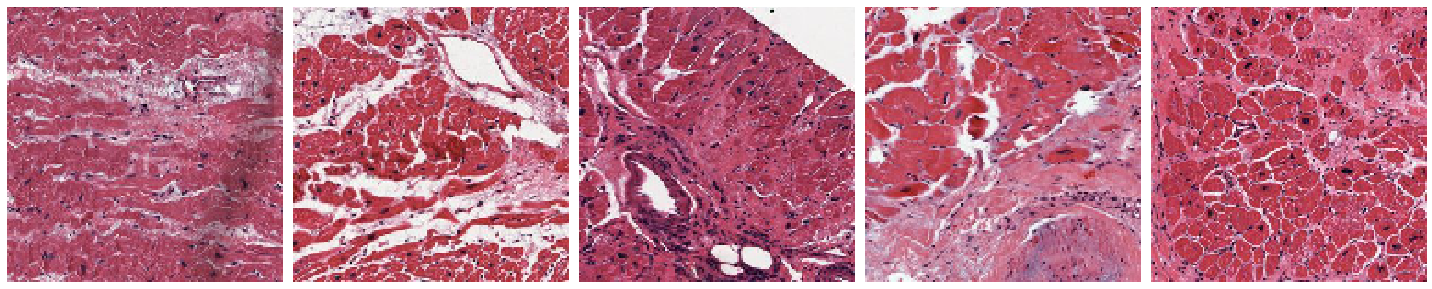

In [14]:
plotImages(sample_training_images[:5])

## Create the model

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 512 units on top of it that is activated by a `relu` activation function.

In [15]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

### Compile the model

As all the other black magic in ML, the *ADAM* optimizer and *binary cross entropy* loss function are used here. To view training and validation accuracy for each training epoch, pass the `metrics` argument.

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

View all the layers of the network using the model's `summary` method:

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0

### Train the model

Use the `fit_generator` method of the `ImageDataGenerator` class to train the network.

In [18]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 7 steps, validate for 7 steps
Epoch 1/25
7/7 [==============================] - 5s 750ms/step - loss: 1.3914 - accuracy: 0.4967 - val_loss: 0.6919 - val_accuracy: 0.5335
Epoch 2/25
7/7 [==============================] - 4s 548ms/step - loss: 0.6901 - accuracy: 0.5206 - val_loss: 0.6967 - val_accuracy: 0.5335
Epoch 3/25
7/7 [==============================] - 4s 552ms/step - loss: 0.6902 - accuracy: 0.5229 - val_loss: 0.6851 - val_accuracy: 0.5335
Epoch 4/25
7/7 [==============================] - 4s 540ms/step - loss: 0.6882 - accuracy: 0.5092 - val_loss: 0.6948 - val_accuracy: 0.5335
Epoch 5/25
7/7 [==============================] - 4s 534ms/step - loss: 0.6822 - accuracy: 0.5206 - val_loss: 0.6704 - val_accuracy: 0.5335
Epoch 6/25
7/7 [==============================] - 4s 532ms/step - loss: 0.6630 - accuracy: 0.5080 - val_loss: 0.6341 - val_accuracy: 0

### Visualize training results

Now visualize the results after training the network.

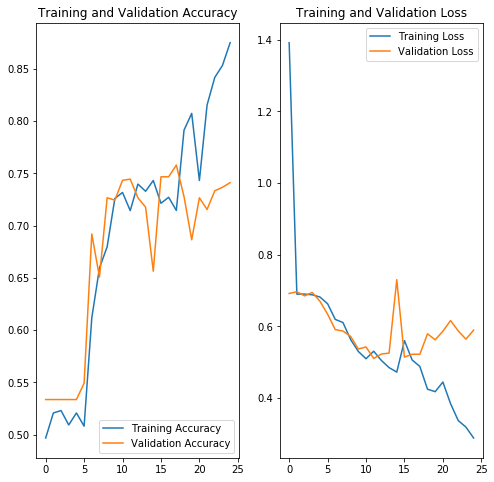

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The training accuracy and validation accuracy are off by large margin and the model has achieved only around **75%** accuracy on the validation set while the training set is well on its way to **85%**. If given more epochs, the accuracy will diverge further. So does the loss.

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 75% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of *overfitting*.

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. The *data augmentation* and *dropout* are popular techniques to overcome that.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. One way to fix this problem is to augment the dataset so that it has a sufficient number of training examples. Data augmentation takes the approach of generating more training data from existing training examples by augmenting them with random transformations that yield believable-looking images. The goal is the model will never see the exact same picture twice during training. This helps expose the model to more aspects of the data and generalize better.

Implement this in `tf.keras` using the `ImageDataGenerator` class. Pass  different transformations to the dataset and it will take care of applying it during the training process.

### Augment and visualize data

Begin by applying random horizontal flip augmentation to the dataset and see how individual images look like after the transformation.

### Apply horizontal flip

Pass `horizontal_flip` as an argument to the `ImageDataGenerator` class and set it to `True` to apply this augmentation.

In [20]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

In [21]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 1000 images belonging to 2 classes.


Take one sample image from the training examples and repeat it five times so that the augmentation is applied to the same image five times.

In [22]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

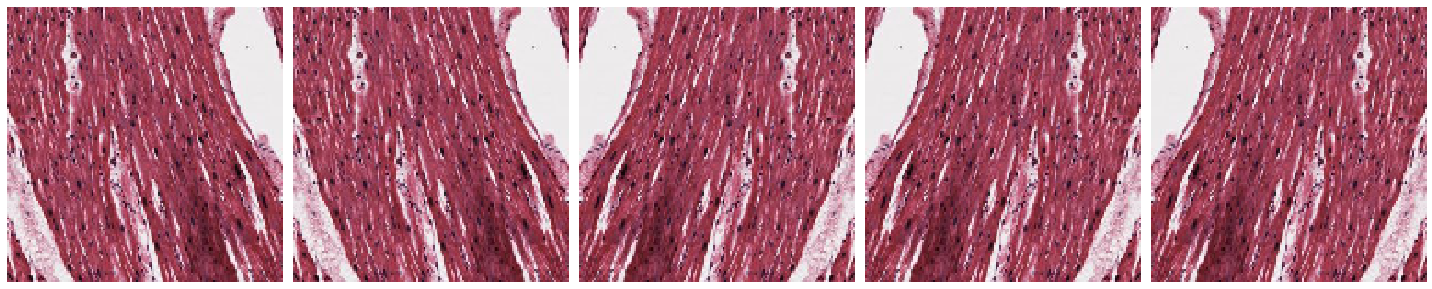

In [23]:
# Re-use the same custom plotting function defined and used
# above to visualize the training images
plotImages(augmented_images)

### Randomly rotate the image

Apply 45 degrees of rotation randomly to the training samples as another augmentation.

In [24]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

In [25]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 1000 images belonging to 2 classes.


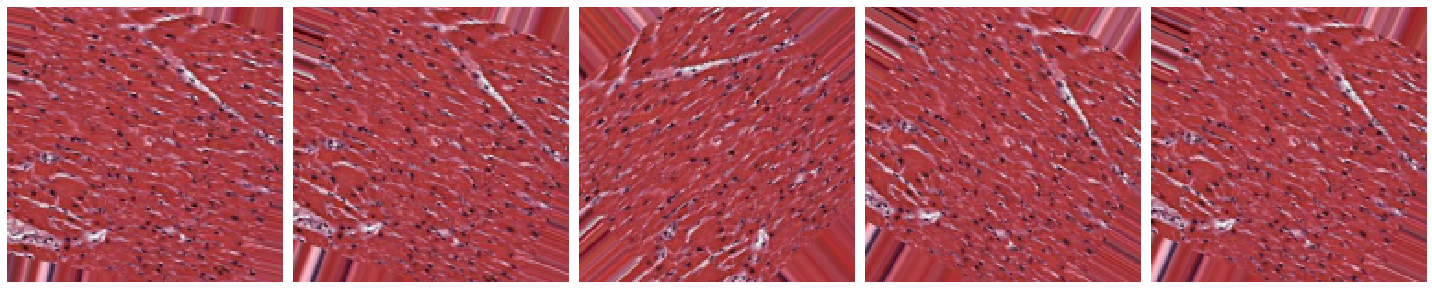

In [26]:
plotImages(augmented_images)

### Apply zoom augmentation

Apply a zoom augmentation to the dataset to zoom images up to 50% randomly.

In [27]:
# zoom_range from 0 - 1 where 1 = 100%.
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5) # 

In [28]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 1000 images belonging to 2 classes.


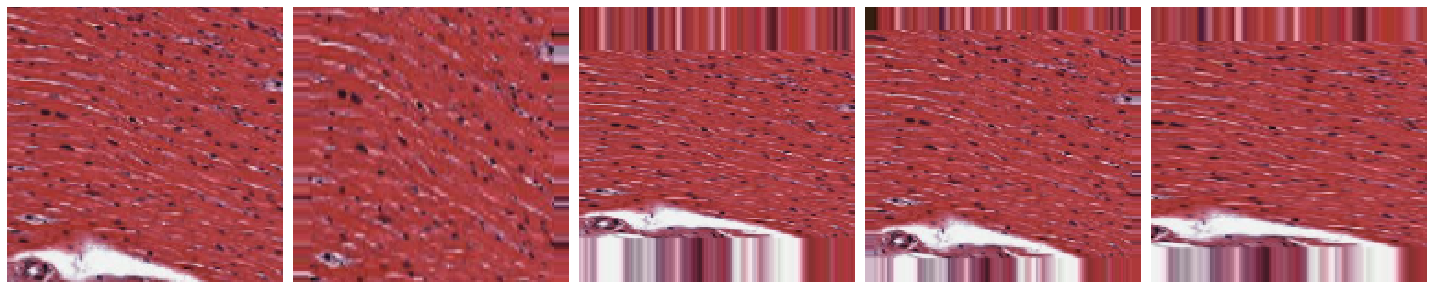

In [29]:
plotImages(augmented_images)

### Put it all together

Apply all the previous augmentations: rescale, 45 degree rotation, width shift, height shift, horizontal flip and zoom augmentation to the training images.

In [30]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

In [31]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 1000 images belonging to 2 classes.


Visualize how a single image would look five different times when passing these augmentations randomly to the dataset.

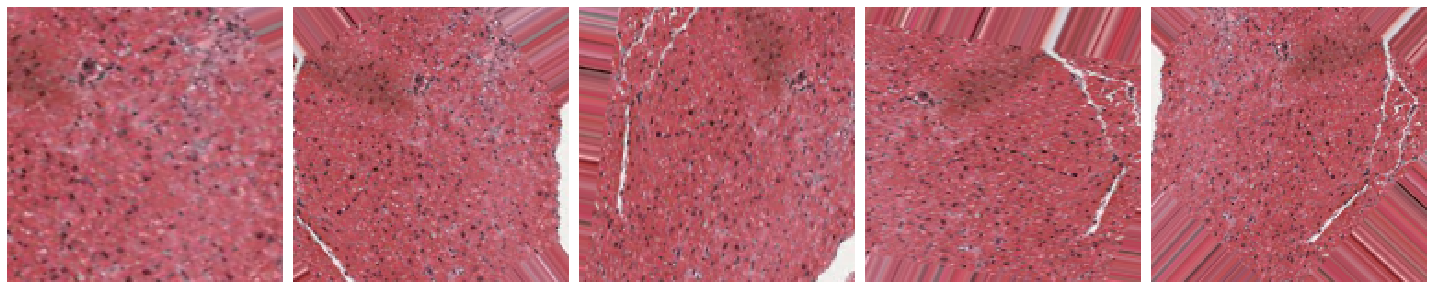

In [32]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Create validation data generator

Generally, only apply data augmentation to the training examples. In this case, only rescale the validation images and convert them into batches using `ImageDataGenerator`.

In [33]:
image_gen_val = ImageDataGenerator(rescale=1./255)

In [34]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 978 images belonging to 2 classes.


## Dropout

Another technique to reduce overfitting is to introduce *dropout* to the network. It is a form of *regularization* that forces the weights in the network to take only small values, which makes the distribution of weight values more regular and the network can reduce overfitting on small training examples. Dropout is one of the regularization technique used in multiple ML scenarios, including image classification.

When you apply dropout to a layer it randomly drops out (set to zero) number of output units from the applied layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

When appling 0.1 dropout to a certain layer, it randomly kills 10% of the output units in each training epoch.

Create a network architecture with this new dropout feature and apply it to different convolutions and fully-connected layers.

## Creating a new network with Dropouts

Apply dropout to first and last max pool layers. Applying dropout will randomly set 20% of the neurons to zero during each training epoch. This helps to avoid overfitting on the training dataset. And of course, it could also forget useful knowledge.

In [35]:
model_new = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

### Compile the model

After introducing dropouts to the network, compile the model and view the layers summary.

In [36]:
model_new.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])

model_new.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 18, 18, 64)       

### Train the model

After successfully introducing data augmentations to the training examples and adding dropouts to the network, train this new network:

In [37]:
history = model_new.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 7 steps, validate for 7 steps
Epoch 1/25
7/7 [==============================] - 8s 1s/step - loss: 1.5209 - accuracy: 0.5161 - val_loss: 0.7011 - val_accuracy: 0.5446
Epoch 2/25
7/7 [==============================] - 8s 1s/step - loss: 0.7377 - accuracy: 0.5172 - val_loss: 0.6908 - val_accuracy: 0.5446
Epoch 3/25
7/7 [==============================] - 8s 1s/step - loss: 0.6941 - accuracy: 0.5092 - val_loss: 0.6967 - val_accuracy: 0.5446
Epoch 4/25
7/7 [==============================] - 8s 1s/step - loss: 0.6938 - accuracy: 0.5206 - val_loss: 0.6916 - val_accuracy: 0.5446
Epoch 5/25
7/7 [==============================] - 8s 1s/step - loss: 0.6916 - accuracy: 0.5206 - val_loss: 0.6891 - val_accuracy: 0.5446
Epoch 6/25
7/7 [==============================] - 8s 1s/step - loss: 0.6906 - accuracy: 0.5172 - val_loss: 0.6834 - val_accuracy: 0.5446
Epoch 7/25
7/7 [==============================] - 8s 1s/step - loss: 0.6793 - accuracy: 

### Visualize the model

Visualize the new model after training. There is significantly less overfitting than before. The accuracy suffers slightly. However, there is no divergence in either accuracy or loss in training and verification data sets.

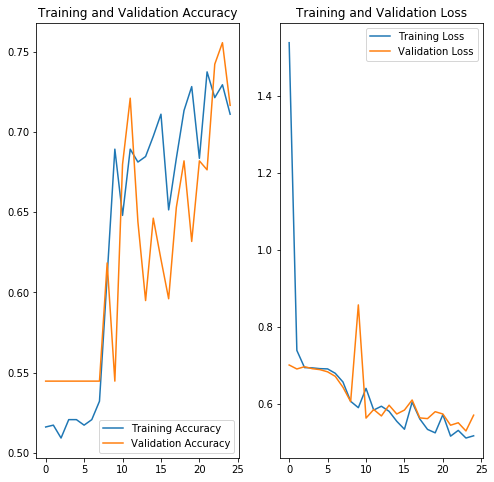

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()